### Simulator

In [14]:
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
#import lightning as L 
import pytorch_lightning as pl

import torch
DEVICE = 'GPU'
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

  0%|          | 0/100000 [00:00<?, ?it/s]

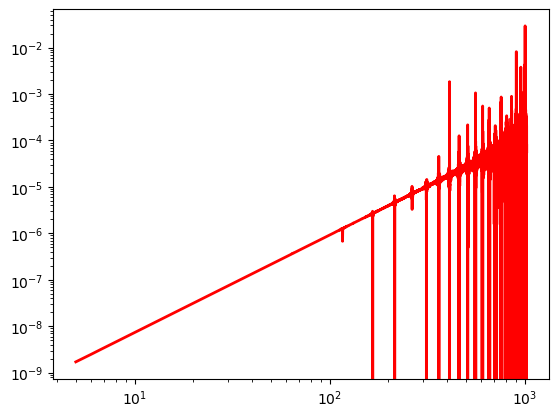

In [15]:
# Simulate data 

fref = 25
CE_PSD = np.genfromtxt("data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(100000) # 100 samples

# Plot simulated data
#for i in range(len(samples)):
#    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)
plt.show()

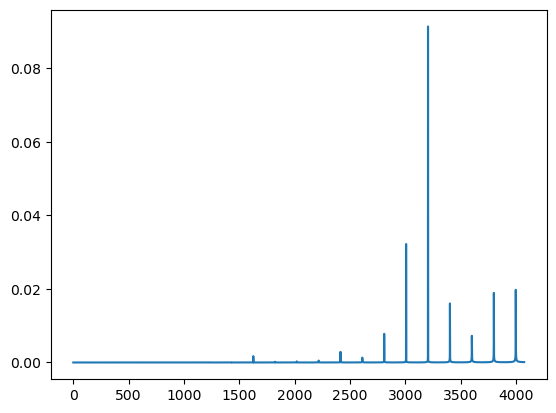

In [16]:
plt.plot(samples[5]['sigma'])
plt.show()

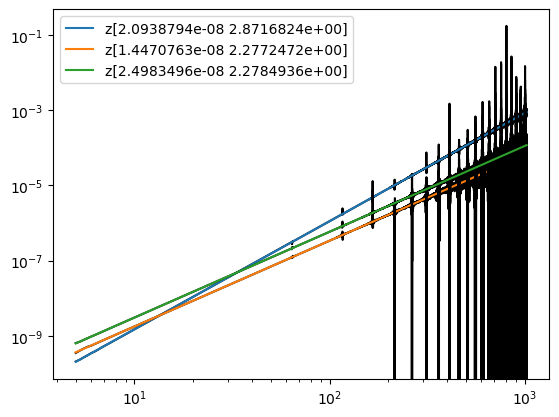

In [17]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()
plt.show()

In [18]:
samples['x']

array([[ 3.8277932e-09,  3.9471186e-09,  4.0714312e-09, ...,
         8.5284533e-05,  1.0792034e-04,  1.1162375e-04],
       [ 1.0123919e-09,  1.1495876e-09,  1.2761906e-09, ...,
         2.2062866e-04,  4.6932884e-04,  4.6154953e-04],
       [ 3.5521730e-10,  4.1024448e-10,  4.6593740e-10, ...,
         2.3220514e-04,  6.1904204e-05,  1.6823811e-04],
       ...,
       [ 5.7722294e-09,  6.0359899e-09,  6.2804926e-09, ...,
         2.9295003e-05, -1.7705806e-05,  8.0142476e-05],
       [ 2.2258717e-09,  2.4270776e-09,  2.6186930e-09, ...,
        -1.0701668e-05, -5.7340654e-05,  6.2224521e-05],
       [ 7.6380258e-10,  8.4878188e-10,  9.4563068e-10, ...,
        -8.4287516e-05, -4.3667602e-05,  5.2450428e-05]], dtype=float32)

##  Autoencoder


In [19]:
import torch.nn as nn
from torchsummary import summary

# Define Autoencoder

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(4076, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
  
        )
        self.decoder = nn.Sequential(
            nn.Linear(16,64),
            nn.ReLU(),
            nn.Linear(64,256),
            nn.ReLU(),
            nn.Linear(256,1024),
            nn.ReLU(),
            nn.Linear(1024,4076)
    
           #nn.ReLU()

        )

        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x



model = Autoencoder()
summary(model, input_size=(1, 4076))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       4,174,848
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       262,400
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       16,448
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       1,040
|    └─ReLU: 2-8                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-9                       1,088
|    └─ReLU: 2-10                        --
|    └─Linear: 2-11                      16,640
|    └─ReLU: 2-12                        --
|    └─Linear: 2-13                      263,168
|    └─ReLU: 2-14                        --
|    └─Linear: 2-15                      4,177,900
├─Dropout: 1-3                           --
Total params: 8,913,532
Trainable params: 8,913,532
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       4,174,848
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       262,400
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       16,448
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       1,040
|    └─ReLU: 2-8                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-9                       1,088
|    └─ReLU: 2-10                        --
|    └─Linear: 2-11                      16,640
|    └─ReLU: 2-12                        --
|    └─Linear: 2-13                      263,168
|    └─ReLU: 2-14                        --
|    └─Linear: 2-15                      4,177,900
├─Dropout: 1-3                           --
Total params: 8,913,532
Trainable params: 8,913,532
Non-trainable params: 0

In [20]:
# Pre-Process Data

from torch.utils.data import TensorDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

x_samples = samples['x'] 
m_samples = samples['m']


# Scaling data across each sample (need to transpose first)
transposed_x = x_samples.T
transposed_m = m_samples.T

scaler = StandardScaler()
#scaler = MinMaxScaler()

x_T_scaled = scaler.fit_transform(transposed_x)
m_T_scaled = scaler.fit_transform(transposed_m)

x_scaled = x_T_scaled.T
m_scaled = m_T_scaled.T

x_train, x_test, m_train, m_test = train_test_split(x_scaled, m_scaled, test_size=0.1)

from torch.utils.data import TensorDataset

# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
m_train_tensor = torch.tensor(m_train, dtype=torch.float32)
m_test_tensor = torch.tensor(m_test, dtype=torch.float32)

# Define Data Loaders
train_dataset = TensorDataset(x_train_tensor, m_train_tensor)
test_dataset = TensorDataset(x_test_tensor, m_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
x_train_tensor.shape

torch.Size([90000, 4076])

In [22]:
# Check that normalization worked
print("Min: ",np.min(x_scaled[0,:]))
print("Max: ",np.max(x_scaled[0,:]))
print("Mean: ",np.average(x_scaled[0,:]))
print("Var: ", np.var(x_scaled[0,:]))

Min:  -17.23996
Max:  57.54629
Mean:  -9.358924e-10
Var:  1.0


In [23]:
x_train.shape

(90000, 4076)

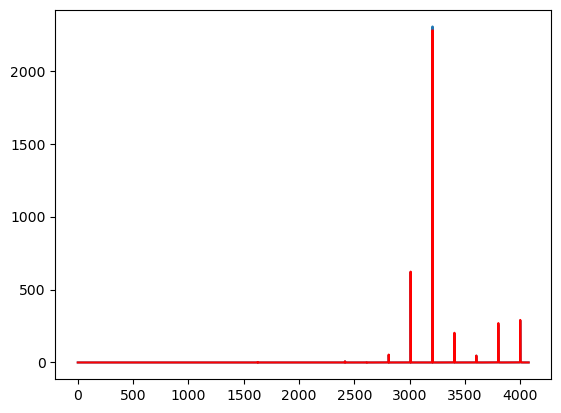

In [24]:
# Getting variance in each dimension of data
def Var_By_Column(data):
    
    sigma = np.zeros(len(data[0,:]))

    for i in range(len(sigma)):
        sigma[i] = np.var(data[:,i])

    return sigma

sig_test = Var_By_Column(x_test)
sig_train = Var_By_Column(x_train)

plt.plot(sig_test)
plt.plot(sig_train, c="r")
plt.show()

In [25]:
# Define weighted loss function
def MSELoss_Weighted(sigma, predictions, targets):
    """""
    Computes the mean squared error (MSE) loss between predictions and targets, 
    weighted by the variance of the dimension
    
    Args:
        predictions (torch.Tensor): The predicted values.
        targets (torch.Tensor): The target values.
        
    Returns:
        torch.Tensor: The computed MSE loss.
    """
    assert predictions.shape == targets.shape, "Shapes of predictions and targets must match"

    sigma = torch.Tensor(sigma)
    
    squared_error = 1/sigma**2 * (predictions - targets)**2 
    
    mse_loss = torch.mean(squared_error)
    
    return mse_loss

Epoch [1/10], Loss: 2613.5480377387
Epoch [2/10], Loss: 1247.6989984592
Epoch [3/10], Loss: 1053.2207826063
Epoch [4/10], Loss: 937.2758958984
Epoch [5/10], Loss: 827.8260391764
Epoch [6/10], Loss: 760.7701896864
Epoch [7/10], Loss: 683.4732148709
Epoch [8/10], Loss: 624.6539006999
Epoch [9/10], Loss: 580.6490271701
Epoch [10/10], Loss: 517.5989236437


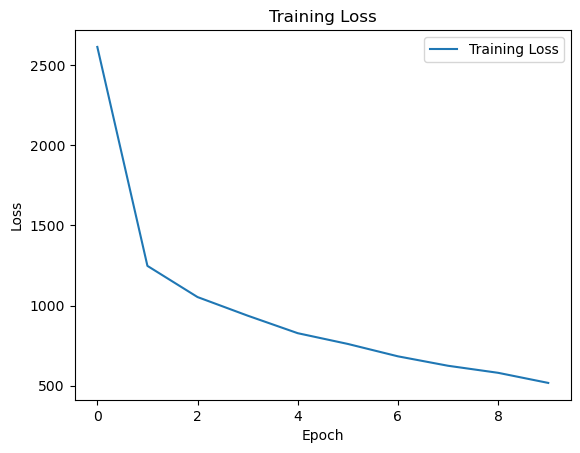

In [26]:
# Autoencoder
model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=.0001) # try smaller lr

train_losses = []
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1)) 
        #loss = criterion(outputs, targets.unsqueeze(1))  
        loss = MSELoss_Weighted(sig_train, outputs, targets.unsqueeze(1))  
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")


plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [27]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.unsqueeze(1)) 
        #test_loss += criterion(outputs, targets.unsqueeze(1)).item() * inputs.size(0)
        test_loss += MSELoss_Weighted(sig_test,outputs, targets.unsqueeze(1)).item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 1402.2269


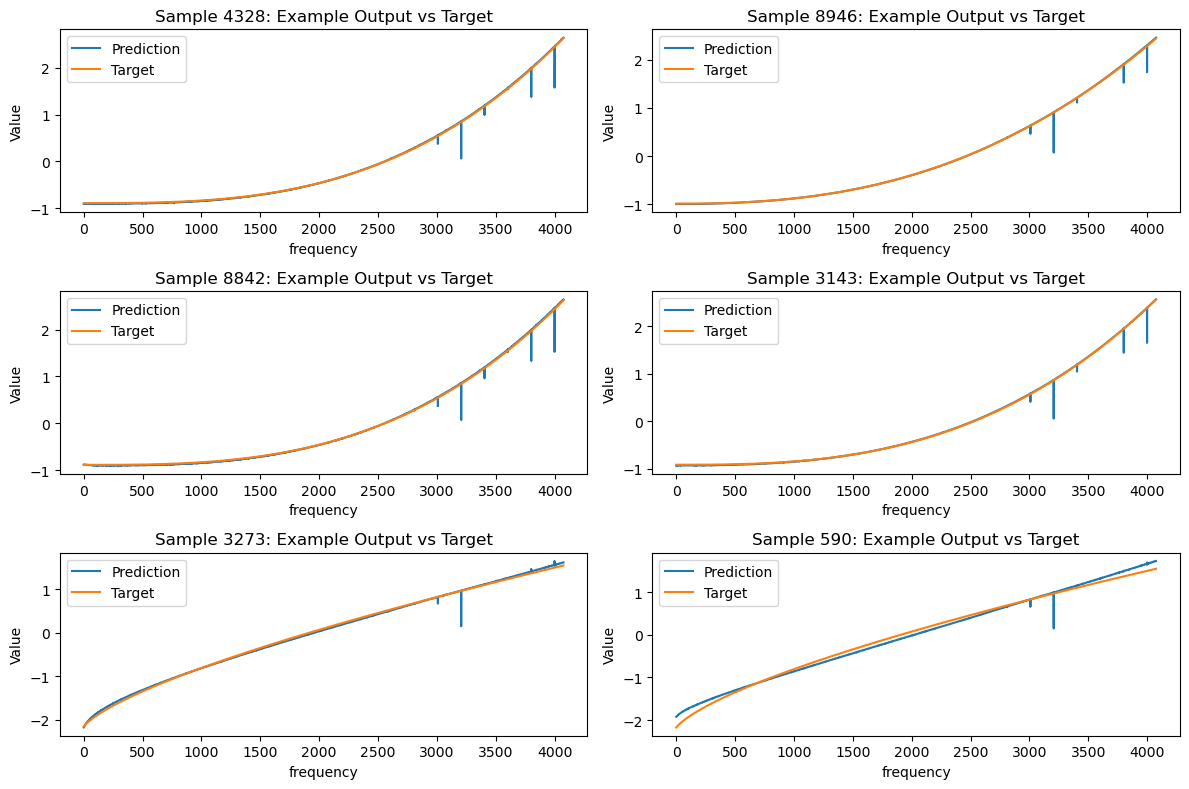

In [28]:
import random

# Randomly select 6 indices
num_samples = 6
random_indices = random.sample(range(len(test_dataset)), num_samples)

# Calculate the number of rows and columns for the subplot layout
num_rows = 3
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    sample, target = test_dataset[idx]

    # Pass the sample through the model to get the prediction
    with torch.no_grad():
        model.eval()
        prediction = model(sample.unsqueeze(0).unsqueeze(0)) 

    axs[row, col].plot(prediction.squeeze().numpy(), label='Prediction')
    axs[row, col].plot(target.numpy(), label='Target')
    axs[row, col].set_xlabel('frequency')
    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Sample {idx}: Example Output vs Target')
    axs[row, col].legend()

# Hide any empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()